In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("SETTING MEMORY GROWTH")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os


import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization



tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Insantes de tiempo futuros a predecir
numPredictions = 600

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). el "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs=1000
# Tamaño del batch
batch = 1024
# Nodos internos
hidden_nodes = 10

# Establecer minimo y maximo de capas y el valor por defecto
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Establecer medida de loss
loss="mean_squared_error"
#loss="mean_absolute_percentage_error"

# Establecer learning rate
lr = [0.0, 1e-2, 1e-3, 1e-4]

SETTING MEMORY GROWTH
TF version: 2.1.0
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [2]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_1min.xlsx", 
                    header=None,
                    engine='openpyxl')[0]
df2 = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2016_1min.xlsx",
                    header = None, 
                    engine = 'openpyxl')[0]

In [3]:
# Data preprocessing: each row will contain the 600 measures for each day , and the 600 measures for the following day
X = pd.DataFrame(np.array(df).reshape(-1, numPredictions))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(601, 1201)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(numPredictions)

# Last row is deleted because it is the one used for the real prediction, 
# it is not useful for the training of the model. 
X.drop(X.tail(1).index,inplace=True)
Y.drop(Y.tail(1).index,inplace=True)

print("X Preproccessed shape: ", X.shape)
print("Y Preproccessed shape: ", Y.shape)
print("---------------------------------------------")

#  Uncomment in order to normalize data
# # Data Normalization
# scaler = MinMaxScaler()
# XNormalized = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 601)])
# YNormalized = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(601, 1201)])

dfPreproccessed = pd.concat([X, Y], axis=1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(X, 
                                                Y, 
                                                test_size = test_size, 
                                                random_state = 0, 
                                                shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, 
                                            yTrain, 
                                            test_size = val_size, 
                                            random_state = 0,
                                            shuffle=False)


# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], yTrain.shape[1], 1))
xval = np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1))
yval = np.reshape(yVal.values, (yVal.shape[0], yVal.shape[1], 1))
xtest = np.reshape(xTest.values, (xTest.shape[0], xTest.shape[1], 1))
ytest = np.reshape(yTest.values, (yTest.shape[0], yTest.shape[1], 1))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

validation_data=xval.reshape((xval.shape[0], xval.shape[1]))

X Preproccessed shape:  (364, 600)
Y Preproccessed shape:  (364, 600)
---------------------------------------------
DataFrame Preproccessed:
           0        1        2        3        4        5        6        7  \
0    167.705  156.535  147.035  131.875  117.075  107.105  100.345   92.940   
1     87.295   80.875   78.365   80.495   81.760   82.825  126.365  301.410   
2     34.420   40.800   44.375   45.200   44.685   46.235   43.175   41.280   
3    329.160  332.735  342.305  355.240  362.155  366.555  367.610  368.375   
4    154.450  147.610  148.305  144.395  143.120  154.575  202.250  269.090   
..       ...      ...      ...      ...      ...      ...      ...      ...   
359  317.855  321.945  325.485  329.215  332.420  335.685  337.965  342.000   
360  154.395  158.445  163.025  166.155  163.665  158.595  155.515  155.680   
361  214.265  185.680  175.200  200.755  217.365  179.530  188.075  325.840   
362  151.390  153.500  153.300  153.665  160.050  171.835  185.110  1


Dimensions afther third dimension added:
xTrain:	(177, 600, 1)
yTrain:	(177, 600, 1)
xVal:	(77, 600, 1)
yVal:	(77, 600, 1)
xTest:	(110, 600, 1)
yTest:	(110, 600, 1)


In [6]:
with tf.device('/gpu:0'):    
# Model definition
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
    model.add(Dense(600, activation="sigmoid"))

    print("Input shape", (xtrain.shape[1], 1))

    print("Summary: ")
    model.summary()

    # Set Epsilon to 1, in order to fix huge MAPE values.
    keras.backend.set_epsilon(1)

    # Model compilation
    model.compile(loss=loss,
                optimizer="adam",
                metrics=[keras.metrics.MAE, keras.metrics.MAPE, keras.metrics.MSE])

    history = model.fit(
        xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
        ytrain,
        epochs=epchs,
        batch_size=batch,
        validation_data=(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
            # validation_data=(xval,yval))

Input shape (600, 1)
Summary: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 600)               6600      
Total params: 7,080
Trainable params: 7,080
Non-trainable params: 0
_________________________________________________________________
Train on 177 samples, validate on 77 samples
Epoch 1/1000
177/177 [==============================] - 1s 7ms/sample - loss: 196696.7500 - mean_absolute_error: 371.4379 - mean_absolute_percentage_error: 99.2172 - mean_squared_error: 196696.7500 - val_loss: 143395.3438 - val_mean_absolute_error: 318.0009 - val_mean_absolute_percentage_error: 99.4544 - val_mean_squared_error: 143395.3438
Epoch 2/1000
177/177 [==============================] - 0s 714us/sample - loss: 196696.0000 - me

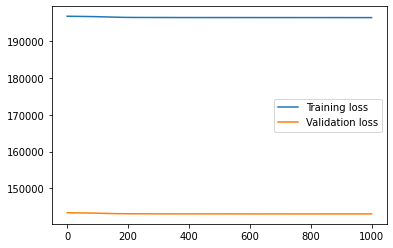

77/77 [==============================] - ETA: 0s - loss: 110226.1875 - mean_absolute_error: 274.0319 - mean_absolute_percentage_error: 98.6459 - mean_squared_error: 110226.18 - 0s 3ms/sample - loss: 143081.7216 - mean_absolute_error: 317.5084 - mean_absolute_percentage_error: 99.0190 - mean_squared_error: 143081.7188
Score: [143081.7215909091, 317.50842, 99.01902, 143081.72]


In [7]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval)
print('Score:', score)